In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import norm
import statsmodels.api as sm
import warnings
warnings.filterwarnings('ignore')

# Introduction:

West Nile Virus (WNV) is spread to people when they have been bitten by a mosquito carrying the virus. There are no vaccines to prevent the spread of the virus or treatments for the virus once it has infected a human. This is why it is important to monitor mosquito activity in the city to predict hotspots, especially during the hotter months, when there are more mosquitoes around. 
The following report will explore the data that has been gathered between 2007 to 2019 in order to build models that can predict WNV prevelance and monitor mosquito numbers in the city.

---

#### Data Dictionary:

`Year` :Year that the WNV test is performed	*int64*

`Week` :Week that the WNV test is performed	*int64*

`Address Block`: Address of the location of trap.	*string*

`Block`: Block number of address	*int64*	

`Trap`: Id of the trap *string*
- Some traps are "satellite traps". These are traps that are set up near (usually within 6 blocks) an established trap to enhance surveillance efforts. Satellite traps are post fixed with letters. For example, T220A is a satellite trap to T220.

`Trap type`: Type of trap	*string*

`Date`: Date and time that the WNV test is performed *string*
- Please note that not all the locations are tested at all times. Also, records exist only when a particular species of mosquitoes is found at a certain trap at a certain time.

`Mosquito number`: Number of mosquitoes caught in this trap *int64*
- These test results are organized in such a way that when the number of mosquitoes exceed 50, they are split into another record (another row in the dataset), such that the number of mosquitoes are capped at 50.

`Mosquito ID`: Id for Mosquito species *string*

`WNV Present`: Whether West Nile Virus was present in these mosquitos	string

`Species`: Mosquito species *string*

`Lat`:Latitude of trap *float64*

`Lon`: Longitude of trap *float64*



---

# Exploring the Data:

In [2]:
df = pd.read_csv('mosquito_data_part_2.csv')

In [3]:
df.head(5)

,Year,Week,Address Block,Trap,Trap type,Date,Mosquito number,WNV Present,Species,Lat,Lon,Month
0,2019,39,100XX W OHARE AIRPORT,T910,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.977738,-87.880969,9
1,2019,39,52XX S KOLMAR AVE,T114,GRAVID,2019-09-26 00:09:00,1,negative,CULEX RESTUANS,41.798211,-87.736925,9
2,2019,39,58XX N WESTERN AVE,T028,GRAVID,2019-09-26 00:09:00,2,negative,CULEX RESTUANS,41.987245,-87.689417,9
3,2019,39,39XX N SPRINGFIELD AVE,T228,GRAVID,2019-09-26 00:09:00,1,negative,CULEX RESTUANS,41.953664,-87.724987,9
4,2019,39,131XX S BRANDON AVE,T209,GRAVID,2019-09-26 00:09:00,9,negative,CULEX RESTUANS,41.657069,-87.546049,9


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18495 entries, 0 to 18494
Data columns (total 12 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             18495 non-null  int64  
 1   Week             18495 non-null  int64  
 2   Address Block    18495 non-null  object 
 3   Trap             18495 non-null  object 
 4   Trap type        18495 non-null  object 
 5   Date             18495 non-null  object 
 6   Mosquito number  18495 non-null  int64  
 7   WNV Present      18495 non-null  object 
 8   Species          18495 non-null  object 
 9   Lat              18495 non-null  float64
 10  Lon              18495 non-null  float64
 11  Month            18495 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 1.7+ MB


In [5]:
df['Mosquito number'].describe()

count    18495.000000
mean        10.879913
std         13.475066
min          1.000000
25%          2.000000
50%          5.000000
75%         14.000000
max         50.000000
Name: Mosquito number, dtype: float64

As mentioned in the introduction and what is evident from the data dictionary, we have rows that are duplicated due to how the mosquitos were capped at 50. So to deal with this, we will sum these rows together on the `Mosquito number` rows, this will mean that our Max: 50 mosquitos (see previous line of code) will change.

We will do this by grouping on all the columns except the `Mosquito number` column and then passing a sum on this, and assigning to a new dataframe **df1**.
This will sum the duplicated rows by mosquito numbers, increasing our Max number of mosquitos in that column.

In [6]:
df1 = df.groupby(['Year', 'Week', 'Address Block', 'Trap', 'Trap type', 'Date', 'WNV Present', 'Species', 'Lat', 'Lon', 'Month']) \
.sum().reset_index()

In [7]:
df1.describe().T

,count,mean,std,min,25%,50%,75%,max
Year,17391.0,2012.851015,3.733403,2007.000000,2010.000000,2013.000000,2016.000000,2019.000000
Week,17391.0,31.023748,4.382891,20.000000,28.000000,31.000000,34.000000,40.000000
Lat,17391.0,41.848745,0.114416,41.644720,41.746732,41.867599,41.962015,42.017801
Lon,17391.0,-87.706946,0.091301,-87.880969,-87.764737,-87.700238,-87.643076,-87.531051
Month,17391.0,7.631764,1.006986,5.000000,7.000000,8.000000,8.000000,10.000000
Mosquito number,17391.0,11.570582,20.657879,1.000000,2.000000,4.000000,13.000000,500.000000


Now we can see that our Max number of mosquitos is 500.

  ### Numerical columns:

Creating separate dataframes for the numerical and categorical data, to have better insight into the data, and this will help us with our analyses later on.

In [8]:
numeric_cols = list(df1.select_dtypes('number').columns)
numeric_cols

['Year', 'Week', 'Lat', 'Lon', 'Month', 'Mosquito number']

In [9]:
df_num = df1[numeric_cols]
df_num.sample(3)

,Year,Week,Lat,Lon,Month,Mosquito number
11893,2015,31,41.778305,-87.754366,8,2
3164,2009,23,41.820859,-87.665108,6,2
2645,2008,33,41.662387,-87.590180,8,1


  ### Categorical columns:

In [10]:
categ_cols = list(df1.select_dtypes('object').columns)
categ_cols

['Address Block', 'Trap', 'Trap type', 'Date', 'WNV Present', 'Species']

In [11]:
df_cat = df1[categ_cols]
df_cat.sample(3)

,Address Block,Trap,Trap type,Date,WNV Present,Species
2143,100XX W OHARE,T904,GRAVID,2008-07-01 00:07:00,negative,CULEX RESTUANS
10136,70XX N MOSELLE AVE,T008,GRAVID,2014-08-07 00:08:00,negative,CULEX PIPIENS
1220,2XX E 111TH ST,T084,GRAVID,2007-08-21 00:08:00,positive,CULEX PIPIENS


  ### Univariate analysis:

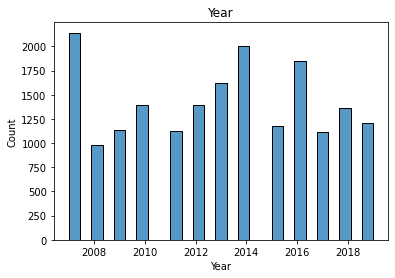

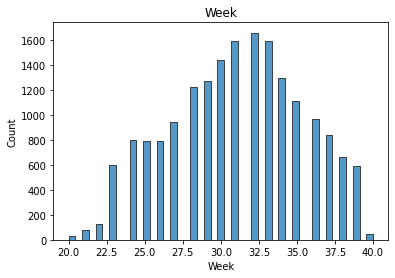

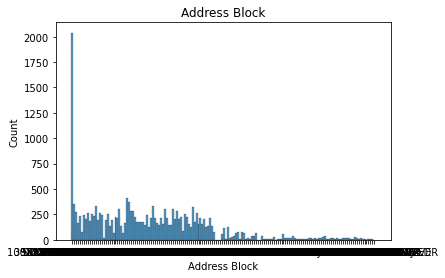

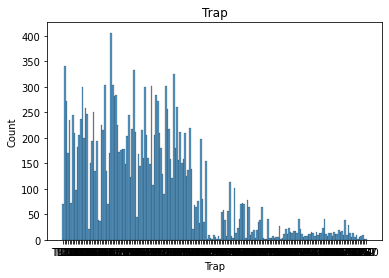

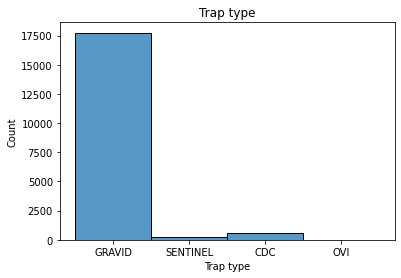

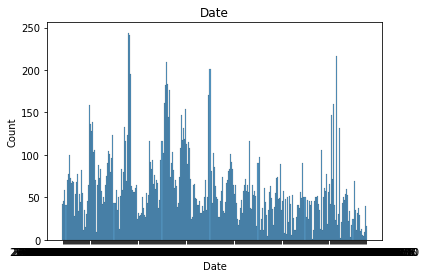

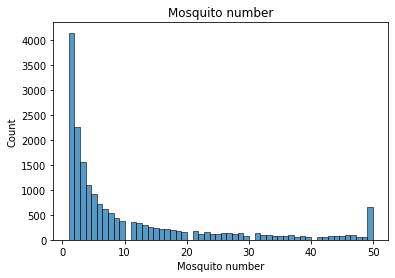

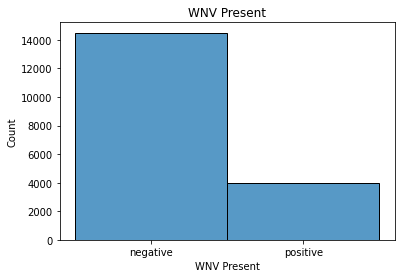

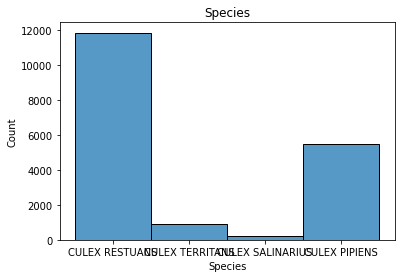

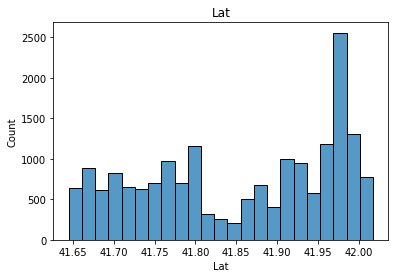

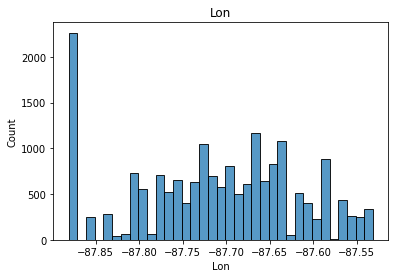

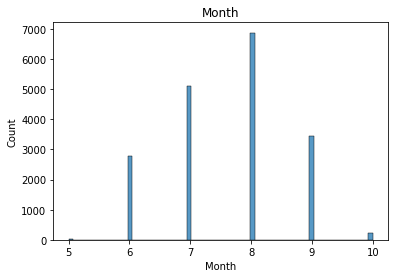

In [14]:
for col in df:
    #if column == 'X': adding customisation depending on a certain column X
        #plt.figure(figuresize=(10,5))
    
    sns.histplot(data=df, x=col)
    plt.title(col)
    plt.show()

  ### Bivariate analysis:

A couple of questions come to mind while looking at the data, for this we will use the df1 data frame, as it still contains the `Trap type` column.

In [15]:
traptype_mosqnum = df1.groupby('Trap type')['Mosquito number'].count()
traptype_mosqnum

Trap type
CDC           474
GRAVID      16719
OVI             1
SENTINEL      197
Name: Mosquito number, dtype: int64

*Which Trap has caught the largest number of mosquitos*?

If we look at a simple count of Mosquito number against the trap types, it shows that 96% of the mosquitos were caught using the GRAVID trap.

In [16]:
species_traptype = df1.groupby('Species')['Trap type'].value_counts(normalize=True)*100
sptrty_unstack = species_traptype.unstack()

In [17]:
sptrty_unstack

Trap type,CDC,GRAVID,OVI,SENTINEL
Species,,,,
CULEX PIPIENS,6.201849,93.432203,0.01926,0.346687
CULEX RESTUANS,1.084697,97.333454,NaN,1.581849
CULEX SALINARIUS,9.009009,90.540541,NaN,0.450450
CULEX TERRITANS,1.312910,98.358862,NaN,0.328228


---

# Part 1 - Basic Analysis

## 1.

#### 1. Converting the `WNV Present` column to binary:

In our DataFrame we have a column `WNV Presen` which shows us whether WNV virus was present in our test or not resent, denoted by Positive and Negative respectively. We can change this to a binary format using 1 and 0 as follows:
 - Positive = 1
 - Negative = 0

In [18]:
#Using the replace function to change the values in column WNV Present:

for row in df1['WNV Present']:
    if row == 'positive':
        df1['WNV Present'] = df1['WNV Present'].replace([row], 1)
    else:
        df1['WNV Present'] = df1['WNV Present'].replace([row], 0)

If we check our DataFram the `WNV Present` column should now contain 1 and 0.

In [19]:
df1.sample(5)

,Year,Week,Address Block,Trap,Trap type,Date,WNV Present,Species,Lat,Lon,Month,Mosquito number
11050,2014,38,51XX N MONT CLARE AVE,T223,GRAVID,2014-09-18 00:09:00,1,CULEX PIPIENS,41.974530,-87.804584,9,16
3070,2009,21,70XX W ARMITAGE AVE,T151,GRAVID,2009-06-02 00:06:00,0,CULEX PIPIENS,41.916135,-87.801093,6,1
15611,2018,30,61XX N LEMONT AVE,T012,GRAVID,2018-07-26 00:07:00,0,CULEX RESTUANS,41.993564,-87.745420,7,1
17092,2019,34,3XX W 104TH ST,T095,GRAVID,2019-08-22 00:08:00,1,CULEX RESTUANS,41.705328,-87.632947,8,1
3295,2009,25,75XX N OAKLEY AVE,T148,GRAVID,2009-06-26 00:06:00,0,CULEX RESTUANS,42.017801,-87.687601,6,2


#### 2. Creating dummy variables from the Trap type column
using the `pd.get_dummies()` function, the variables in column `Trap type` will be split into separate columns containing 1 and 0.
Each time a row coincides with a trap type, that row will have a 1 in the corresponding trap type column, and a 0 in the rest of the trap type columns. We will drop the `OVI` column that the function creates because it contains redundant information, as a value of 0 in each of the other columns is essentially the same as a 1 in the `OVI` column.

In [20]:
df1['Trap type'].unique()

array(['GRAVID', 'CDC', 'OVI', 'SENTINEL'], dtype=object)

In [21]:
df2 = pd.get_dummies(df1["Trap type"])
df2.drop(columns=['OVI'], inplace=True)
df2

,CDC,GRAVID,SENTINEL
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
17386,0,1,0
17387,0,1,0
17388,0,1,0
17389,0,1,0


Next we concatenate our df2 (dummy variables matrix) to our df1 dataframe on the axis=1 to, also assigning this to a new dataframe df3, this should bring our columns number up to 16 columns.

In [22]:
df3 = pd.concat([df1, df2], axis = 1).reset_index(drop=True)
df3.sample(3)

,Year,Week,Address Block,Trap,Trap type,Date,WNV Present,Species,Lat,Lon,Month,Mosquito number,CDC,GRAVID,SENTINEL
14606,2017,33,101XX S STONY ISLAND AVE,T138B,SENTINEL,2017-08-17 00:08:00,1,CULEX RESTUANS,41.710829,-87.584526,8,96,0,0,1
1849,2007,38,14XX N HUMBOLDT DR,T033,GRAVID,2007-09-24 00:09:00,0,CULEX PIPIENS,41.907285,-87.701395,9,17,0,1,0
5665,2011,27,100XX W OHARE AIRPORT,T906,GRAVID,2011-07-11 00:07:00,0,CULEX RESTUANS,41.977738,-87.880969,7,44,0,1,0


In [23]:
df3.drop(columns=['Trap type'], inplace=True)

Checking our dataframe to ensure the `Trap type` column has been dropped.

In [27]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17391 entries, 0 to 17390
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Year             17391 non-null  int64  
 1   Week             17391 non-null  int64  
 2   Address Block    17391 non-null  object 
 3   Trap             17391 non-null  object 
 4   Date             17391 non-null  object 
 5   WNV Present      17391 non-null  int64  
 6   Species          17391 non-null  object 
 7   Lat              17391 non-null  float64
 8   Lon              17391 non-null  float64
 9   Month            17391 non-null  int64  
 10  Mosquito number  17391 non-null  int64  
 11  CDC              17391 non-null  uint8  
 12  GRAVID           17391 non-null  uint8  
 13  SENTINEL         17391 non-null  uint8  
dtypes: float64(2), int64(5), object(4), uint8(3)
memory usage: 1.5+ MB


In [28]:
df3.shape
print(f'df3 datafram contains {df3.shape[0]} rows and {df3.shape[1]} columns')

df3 datafram contains 17391 rows and 14 columns


In [29]:
df3.nunique().sort_values()

WNV Present           2
CDC                   2
GRAVID                2
SENTINEL              2
Species               4
Month                 6
Year                 13
Week                 21
Address Block       154
Mosquito number     175
Trap                190
Date                298
Lat                2509
Lon                2509
dtype: int64

#### Updating the `num_df` dataframe:

Since we've added three new columns that have numerical values, we need to add these to our num_df dataframe.

In [30]:
numeric_cols1 = list(df3.select_dtypes('number').columns)
numeric_cols1

['Year',
 'Week',
 'WNV Present',
 'Lat',
 'Lon',
 'Month',
 'Mosquito number',
 'CDC',
 'GRAVID',
 'SENTINEL']

In [31]:
df_num1 = df3[numeric_cols1]
df_num1.sample(3)

,Year,Week,WNV Present,Lat,Lon,Month,Mosquito number,CDC,GRAVID,SENTINEL
7739,2012,38,0,41.883772,-87.716168,9,1,0,1,0
482,2007,29,0,41.704687,-87.564236,7,55,1,0,0
11378,2015,24,0,41.798211,-87.736925,6,5,0,1,0


---

# Part 2 - Statistical Analysis

#### 1. Investigating statistical significance between mosquito species and West Nile Virus occurance.


What are we looking at?
- Species: categorical, comprised of four different species, *CULEX RESTUANS*, *CULEX TERRITANS*, *CULEX SALINARIUS*, and *CULEX PIPIENS*.
- WNV Present: binary, consiting of either a 1 or 0: 1 for **Positive** meaning these mosquitos carry the WNV, and 0 for **Negative**.

Defining our assumptions:
- $H_0$: There is no relationship between mosquito species and the occurance of WNV.
- $H_1$: There is _some relationship_ between mosquito species and the occurance of WNV

To test for the statistical significance, we carry out a Chi2-contingency test, because we are comparing two categorical variables.

First, we create a **contigency table**, containing the different number of observations for each species of mosquito.



In [32]:
#Grouping by species and the count of negative and positive tests for each:
wnv_pre = df3.groupby('Species')['WNV Present'].value_counts().unstack().reset_index()

#Renaming the columns of the table to make things clearer:
wnv_pre.columns = ['Species', 'wnv_negative', 'wnv_positive']

#Setting species column as the index:
wnv_pre = wnv_pre.set_index('Species')

#Table view:
print('Contigency table')
wnv_pre

Contigency table


,wnv_negative,wnv_positive
Species,,
CULEX PIPIENS,3972,1220
CULEX RESTUANS,9021,2042
CULEX SALINARIUS,215,7
CULEX TERRITANS,900,14


A heatmap to better visualise the prevelance:

In [33]:
cont_prop = round((wnv_pre/wnv_pre.sum())*100, 3)
cont_prop

,wnv_negative,wnv_positive
Species,,
CULEX PIPIENS,28.154,37.161
CULEX RESTUANS,63.942,62.199
CULEX SALINARIUS,1.524,0.213
CULEX TERRITANS,6.379,0.426


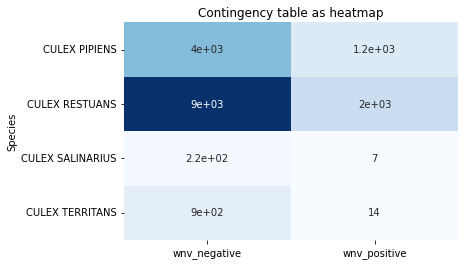

In [34]:
sns.heatmap(wnv_pre,
            cmap="Blues", annot=True, cbar=False)
plt.title('Contingency table as heatmap')
plt.show()

In [35]:
print(stats.chi2_contingency(wnv_pre))
print('    ')
if stats.chi2_contingency(wnv_pre)[1] < 0.05:
        print(f'The p-value {stats.chi2_contingency(wnv_pre)[1]} is <0.05, thus statistically significant.')

(289.06184352112183, 2.317119160315453e-62, 3, array([[4211.87602783,  980.12397217],
       [8974.57328503, 2088.42671497],
       [ 180.09177161,   41.90822839],
       [ 741.45891553,  172.54108447]]))
    
The p-value 2.317119160315453e-62 is <0.05, thus statistically significant.


The p-value is very very small, this suggests that we reject our $H_0$ hypothesis, and that we have less than a 5% probability the null is correct (and the results are random). However, this does not mean that we have 95% probability that our $H_1$ is true, so we fail to reject it.
> But we can infer from what we have calculated that we could observe a relationship between mosquito species and the prevelance of WNV. However this depends on whether we can faily compare the numbers of specific species caught to infer that the species does account for prevelance of WNV. Furthermore, the way the testing is carried out further determines how we interpret what we are seeing in the data.


> Question: So if we have a particular species in a number of caught mosquitos does this increase our chances of getting a positive, how does this affect our analysis and does this cause issues in modelling?



#### 2. Investigating correlations with the number of mosquitoes caught:

correlation =

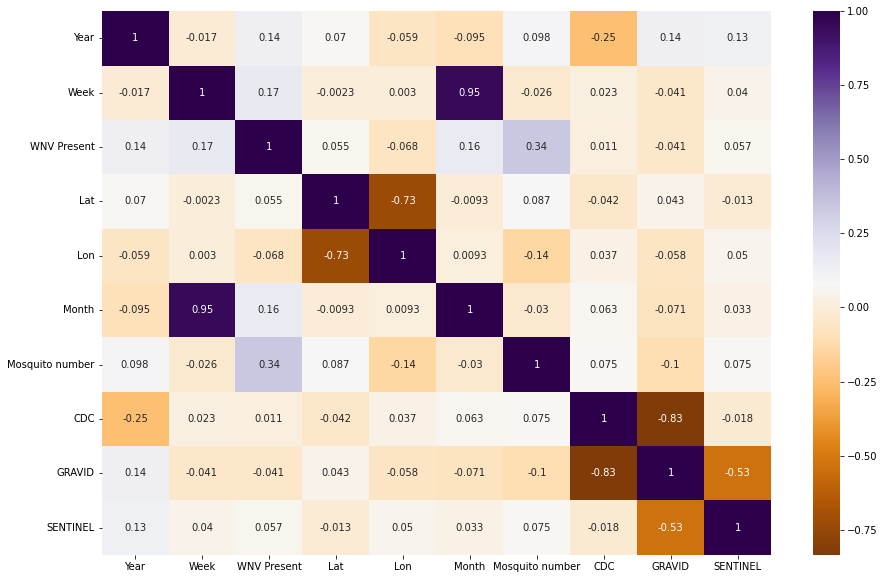

In [36]:
plt.figure(figsize=(15,10))
sns.heatmap(df3.corr(), annot=True, cmap='PuOr')
plt.show()

**Observations**

Looking at the heatmap we don't really notice any strong correlations between Mosquito numbers and the other columns that stand out, however there are correlations between the columns, most notably between Mosquito numbers and WNV Present.
  - `Mosquito number` is positively correlated with:
  
    - `SENTINEL`
    
    - `CDC`
    
    - `WNV Present`
    
  - `Mosquito number` is negativly correlated with:
  
    - `GRAVID`
    
    - `Month`
 
    - `Week`

To see the numbers up close, we will run the following code:

In [37]:
df3[df3.columns[1:]].corr()['Mosquito number'].sort_values()

Lon               -0.144528
GRAVID            -0.104599
Month             -0.030397
Week              -0.025767
SENTINEL           0.075084
CDC                0.075194
Lat                0.086622
WNV Present        0.336526
Mosquito number    1.000000
Name: Mosquito number, dtype: float64

The strongest correlation, although still a weaker one, is between `Mosquito number` and `WNV present`. 

*How are mosquitos tested for WNV?*:

The mosquitos were tested in groups of counted mosquitos. So if a group of 10 mosquitos, for example, is tested we only get one result negative or positive for WNV, this is because the test is carried out by first homogenising (grinding the mosquitos) and then conducting the relavant laboratory techiques for RNA analysis, so if WNV genetic material is found the entire group of 10 mosquitos is considered a 'positive'.


So the higher the number of mosquitos the test was performed on, the higher the probability of seeing a positive result, this creates a bias in the data, making it difficult to compare between groups of mosquito numbers and the prevelance of WNV.

We would see more relevant results if every mosquito caught was individually tested for the presence of WNV, however this is not efficient and would require a lot of resources.

To see whether these positive and negative correlations, although low, have any statistical significance. For that, we will create a loop code to run through all the correlations between Mosquito numbers and the rest of the numerical columns (using the numerical dataframe we created earlier)

In [39]:
corr_df = df_num1.drop(columns=['Mosquito number'])

for col in corr_df:
    
    corr = stats.pearsonr(corr_df[col], df3['Mosquito number'])
    
    print(f'The Pearson correlation coefficient for {col} is {corr[0]}, with a p-value of {corr[1]}')

The Pearson correlation coefficient for Year is 0.0977545480750341, with a p-value of 3.4086279685946815e-38
The Pearson correlation coefficient for Week is -0.02576712939076369, with a p-value of 0.0006779149465776343
The Pearson correlation coefficient for WNV Present is 0.33652604181940193, with a p-value of 0.0
The Pearson correlation coefficient for Lat is 0.08662203916220389, with a p-value of 2.5208184064825616e-30
The Pearson correlation coefficient for Lon is -0.1445281386907279, with a p-value of 8.152195157877397e-82
The Pearson correlation coefficient for Month is -0.030396647076333192, with a p-value of 6.092628690389725e-05
The Pearson correlation coefficient for CDC is 0.07519428649152668, with a p-value of 3.0953021153273027e-23
The Pearson correlation coefficient for GRAVID is -0.10459949490633716, with a p-value of 1.6566909067612184e-43
The Pearson correlation coefficient for SENTINEL is 0.0750844012267073, with a p-value of 3.581245504376958e-23


**Plots of the all the numberical columns against the number of mosquitos counts**

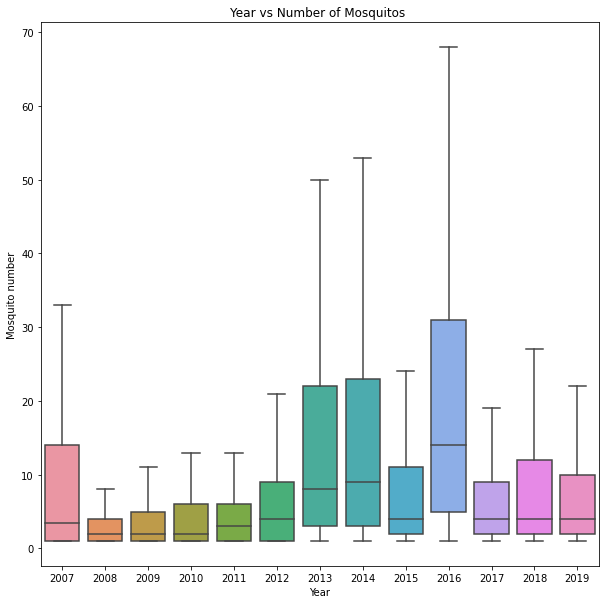

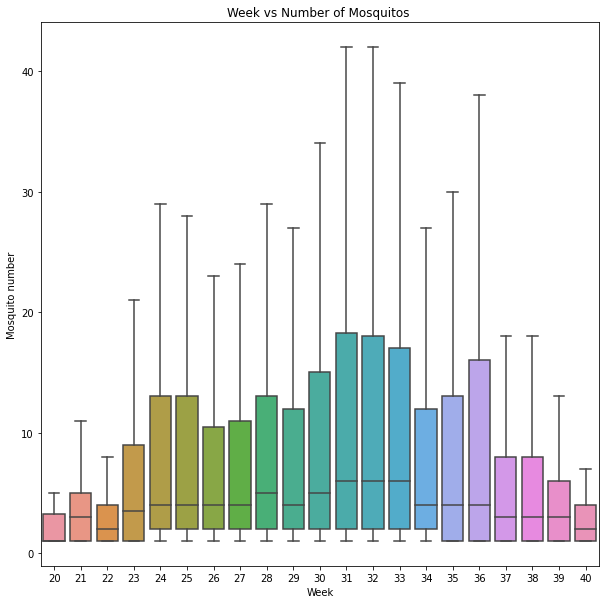

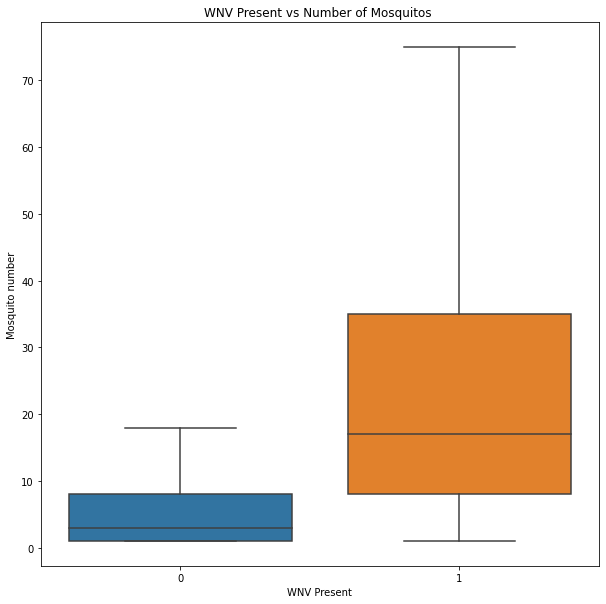

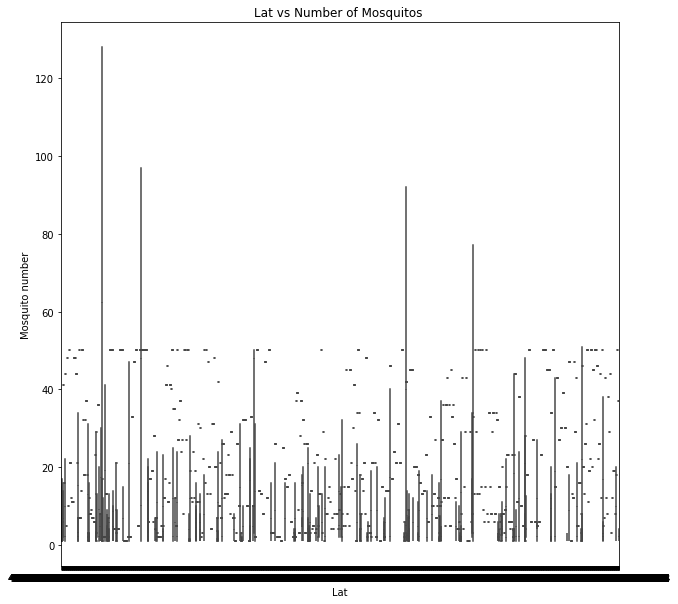

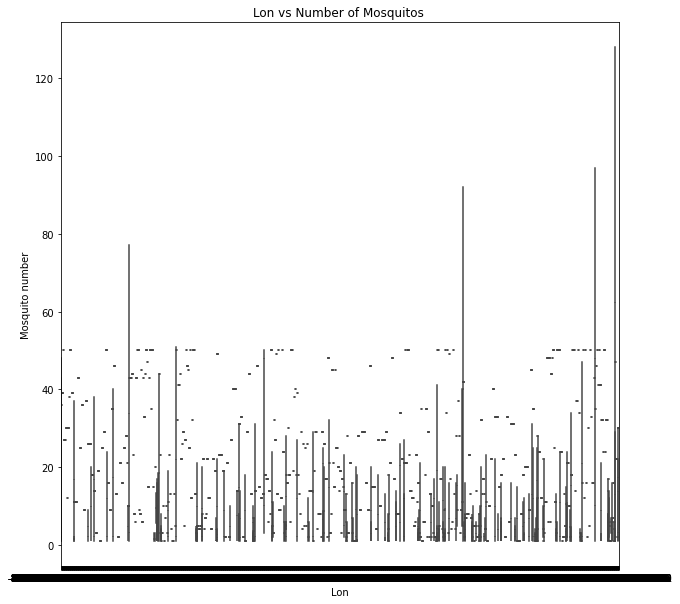

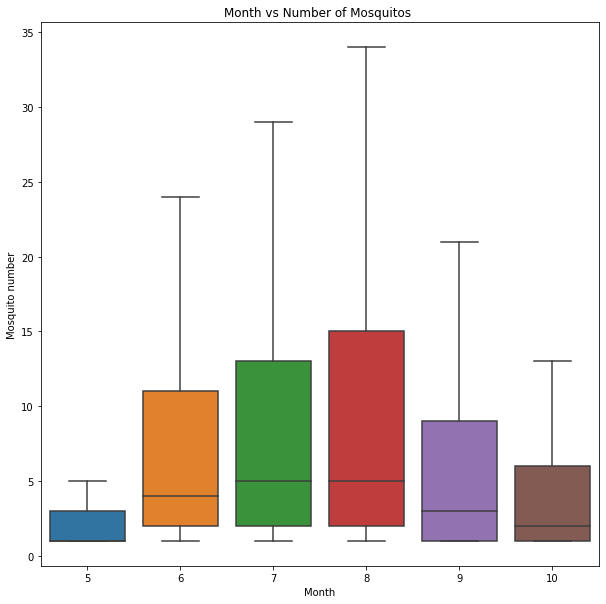

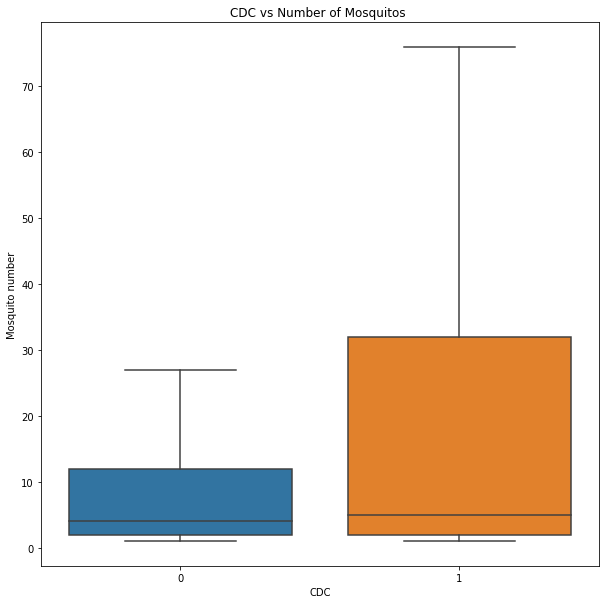

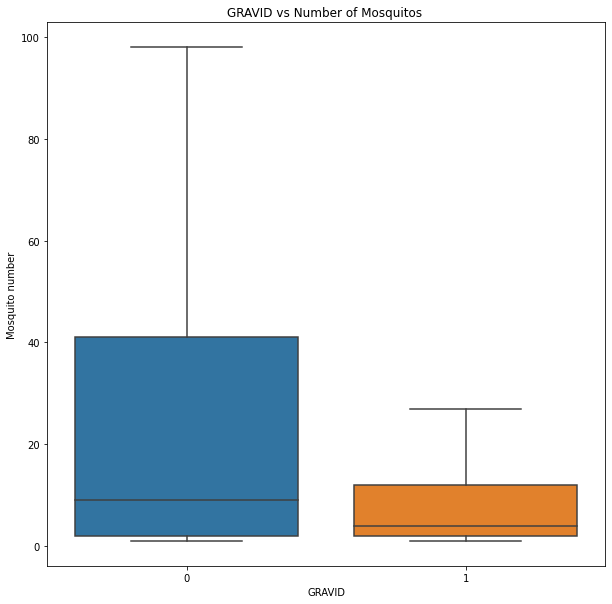

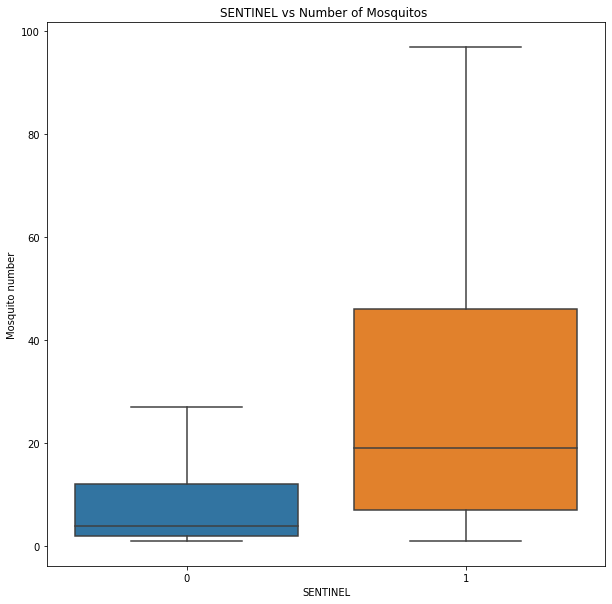

In [40]:
for col in corr_df:
    plt.figure(figsize=(10, 10))
    sns.boxplot(x=corr_df[col], y=df3['Mosquito number'], showfliers=False) 
#showfliers=False hides the outliers to better visualise the plots.
    plt.title(f'{col} vs Number of Mosquitos ')
    plt.show()

As we can see all the p-values are < 0.05 suggesting statististical significance in the relationships between Mosquito number and the other columns.

---

# Linear Regression Model

We want to know if we can predict the number of mosquitos that we will catch in our traps using a linear regression model. 

We saw that our dependent variable `Mosquito number` had statistically significant correlations with all our independent variables.

> **In other words, can we predict the number of mosquitoes we will catch in our traps using our other variables.**


We will look at how the number of mosquitos caught is related to other variables in the study, such as week, year and the trap types. We would also like to look at how the species of the mosquitos has an effect on this. to do that we will create a new dataframe that contains dummy variables of the four species.

In [41]:
df3['Species'].value_counts()

CULEX RESTUANS      11063
CULEX PIPIENS        5192
CULEX TERRITANS       914
CULEX SALINARIUS      222
Name: Species, dtype: int64

In [42]:
#creating dummy variables, and dropping one to avoid multicolinearity.
df_spec = pd.get_dummies(df3["Species"])
df_spec.drop(columns=['CULEX SALINARIUS'], inplace=True)
df_spec

,CULEX PIPIENS,CULEX RESTUANS,CULEX TERRITANS
0,0,1,0
1,0,1,0
2,0,1,0
3,0,1,0
4,0,1,0
...,...,...,...
17386,0,0,1
17387,0,1,0
17388,0,1,0
17389,0,1,0


In [43]:
#concatenating df_spec to a new dataframe df4:
df4 = pd.concat([df_spec, df3], axis = 1).reset_index(drop=True)
df4.sample(3)

,CULEX PIPIENS,CULEX RESTUANS,CULEX TERRITANS,Year,Week,Address Block,Trap,Date,WNV Present,Species,Lat,Lon,Month,Mosquito number,CDC,GRAVID,SENTINEL
14877,0,1,0,2017,37,5XX W 72ND ST,T035,2017-09-14 00:09:00,0,CULEX RESTUANS,41.763371,-87.637873,9,1,0,1,0
8147,0,1,0,2013,28,39XX N SPRINGFIELD AVE,T228,2013-07-12 00:07:00,1,CULEX RESTUANS,41.953668,-87.724985,7,29,0,1,0
14795,0,1,0,2017,36,100XX W OHARE AIRPORT,T910,2017-09-08 00:09:00,0,CULEX RESTUANS,41.977738,-87.880969,9,7,0,1,0


In [44]:
#adding these to a new numarical datafram:
numeric_cols2 = list(df4.select_dtypes('number').columns)
numeric_cols2

['CULEX PIPIENS',
 'CULEX RESTUANS',
 'CULEX TERRITANS',
 'Year',
 'Week',
 'WNV Present',
 'Lat',
 'Lon',
 'Month',
 'Mosquito number',
 'CDC',
 'GRAVID',
 'SENTINEL']

In [45]:
df_num3 = df4[numeric_cols2]
df_num3.sample(3)

,CULEX PIPIENS,CULEX RESTUANS,CULEX TERRITANS,Year,Week,WNV Present,Lat,Lon,Month,Mosquito number,CDC,GRAVID,SENTINEL
4852,0,0,0,2010,32,0,41.681035,-87.533436,8,2,0,1,0
2505,1,0,0,2008,31,0,41.965375,-87.758412,8,1,0,1,0
8361,0,1,0,2013,30,0,41.987245,-87.689417,7,3,0,1,0


our new numerical data dataframe is df_num2, which now contains the Mosquito Species as binary columns.

now we can go ahead with creating our linear model.

###### Creating Independant and Dependant variables (X and y)

In [46]:
df_num3.columns

Index(['CULEX PIPIENS', 'CULEX RESTUANS', 'CULEX TERRITANS', 'Year', 'Week',
       'WNV Present', 'Lat', 'Lon', 'Month', 'Mosquito number', 'CDC',
       'GRAVID', 'SENTINEL'],
      dtype='object')

In [47]:
X_lin = df_num3.drop(columns = ['Mosquito number', 'WNV Present']) #independent variables

y_lin = df_num3['Mosquito number'] #dependent variables

Let's look at what these variables look plotted against each other. We want to see if there is any visible linear trend between any of them and `Mosquito number`.

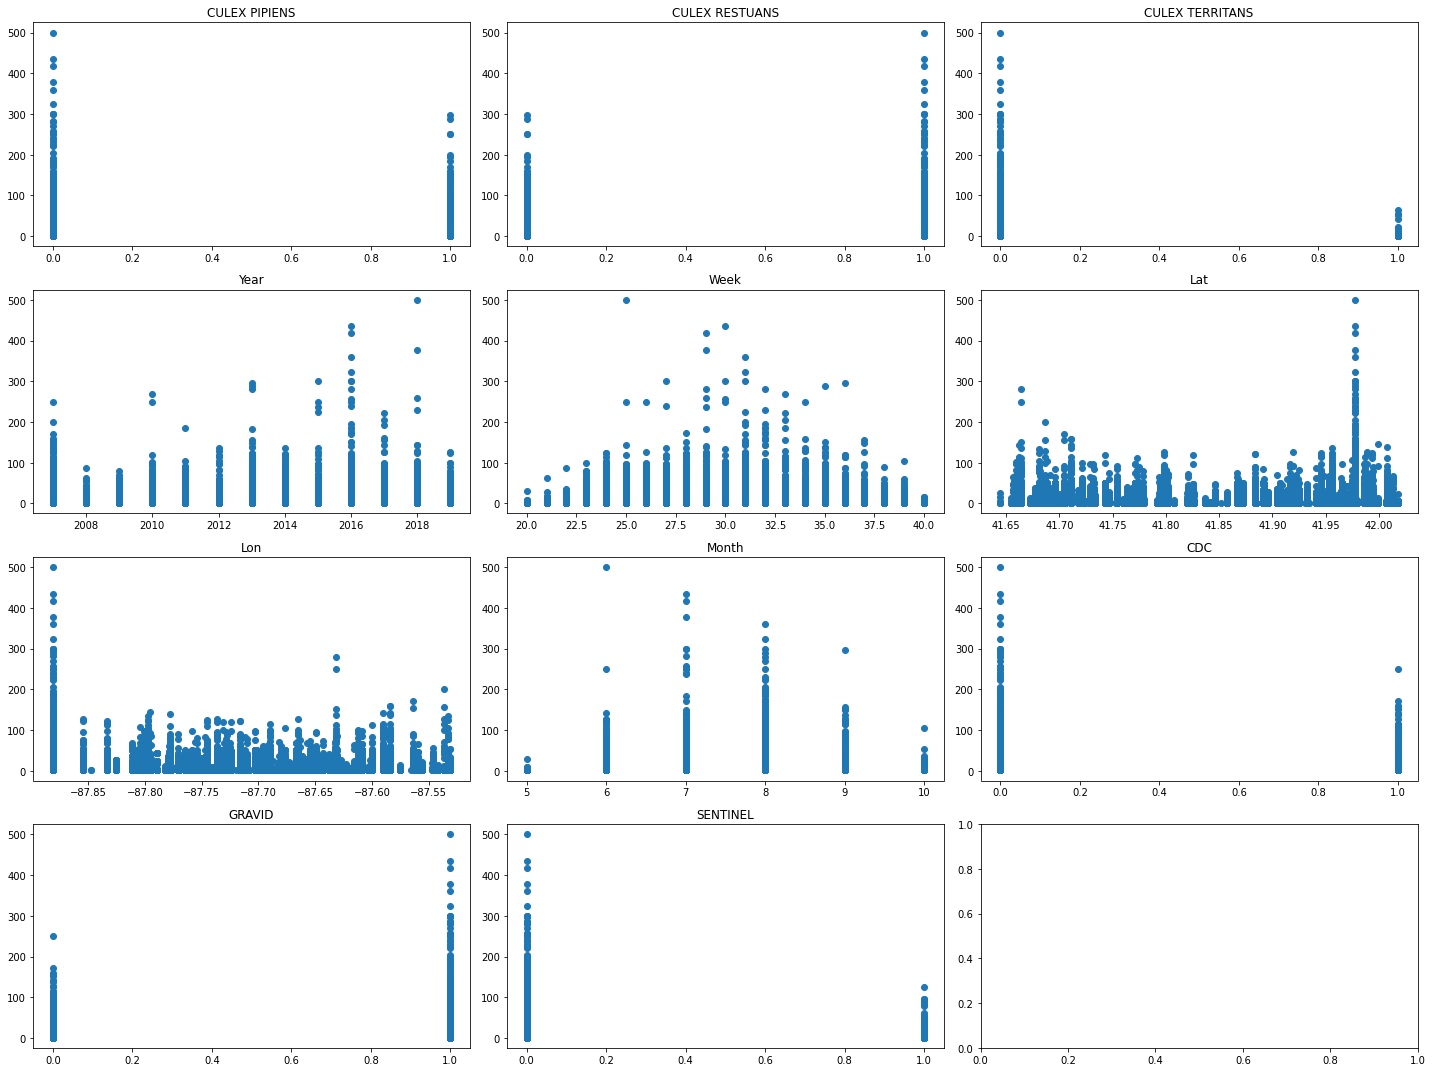

In [48]:
plt.subplots(4,3, figsize=(20,15))

count = 1

for col in X_lin.columns:
    plt.subplot(4,3,count)
    plt.scatter(X_lin[col],y_lin)
    plt.title(col)
    
    count += 1
    
plt.tight_layout()
plt.show()

There doesn't seem to be any distinct linear trend in the plots. However, we can't dismiss that our variables could fit a linear model. For example we can suspect that the time of year has an effect on mosquito numbers, and that the number of mosquitoes caught is dependent on the trap type. We can go further and also assume that trap types that are better at catching all species of mosquitoes will further affect numbers of mosquitoes caught.
so we will test this in the following sections.

### Modelling

                            OLS Regression Results                            
Dep. Variable:        Mosquito number   R-squared:                       0.059
Model:                            OLS   Adj. R-squared:                  0.059
Method:                 Least Squares   F-statistic:                     99.95
Date:                Mon, 20 Jun 2022   Prob (F-statistic):          1.01e-221
Time:                        22:02:31   Log-Likelihood:                -76804.
No. Observations:               17391   AIC:                         1.536e+05
Df Residuals:                   17379   BIC:                         1.537e+05
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const           -4355.4870    187.155    -

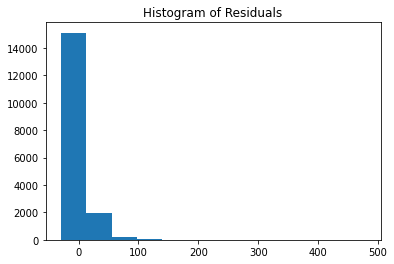

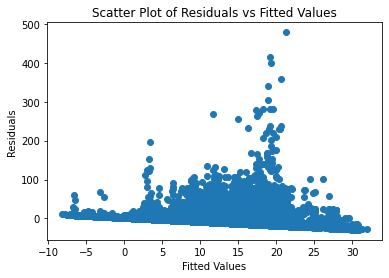

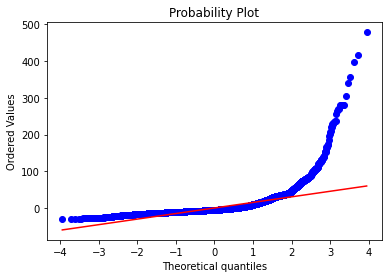

Shapiro-Wilk Test:  (0.5731819868087769, 0.0)


In [51]:
##### Adding constants

X_lin_const = sm.add_constant(X_lin)

##### Instantiating our model

mosquito_model = sm.OLS(y_lin, X_lin_const)

##### Fit the model

mosquito_results = mosquito_model.fit()

##### Checking our Model

print(mosquito_results.summary())

#Residual values
mosquito_residuals = mosquito_results.resid

#Fitted values
mosquito_fitvals = mosquito_results.fittedvalues


plt.figure()
plt.hist(mosquito_residuals, bins = 12)
plt.title('Histogram of Residuals')
plt.show()

plt.figure()
plt.scatter(mosquito_fitvals, mosquito_residuals)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Scatter Plot of Residuals vs Fitted Values')
plt.show()

#Q-Q plot
plt.figure()
stats.probplot(mosquito_residuals, dist="norm", plot = plt);
plt.show()

#Shapiro Wilk Test
print("Shapiro-Wilk Test: ", stats.shapiro(mosquito_residuals))

**Analysis**

We ran our model in a backwards stepwise selection, feeding it all the independent variables at once.

to interpret these results we will look at the p-values for each variable:

- `CULEX TERRITANS`, `Week`, `CDC`, `GRAVID`, `Month`, `SENTINEL` have p-values> 0.05, so according to our model there is no statistical significance to suggest these variables have an effect on the dependent variable (predicting `Mosquito number`)
>According to our model here, the month variable does not have a statistically significant affect on the number of mosquitoes caught. However, we know that during summer months when there are more mosquitoes around, we have better chances of catching mosquitoes in the traps.

- `CULEX PIPIENS`, `CULEX RESTUANS`, `Year`, `Lat`, and `Lon` have p-values <0.05 showing statistical significance in the relationship between these independent variables and the dependent variable. In other terms, the number of Mosquitoes caught is affected by the changes in species year and location.
> However, in terms of `Lat` and `Lon`, although statistical significance is suggested by our model, it is hard to interpret in what way the relationship works, this would require further data wrangling to make this data nominal rather than continous.

Moreover, our R2 value for this model is quite low 0.059, 5.9% of the variation in our dependent variable (Mosquito number) is explained by the model,  further suggesting our model is a weak fit for the data, and that the relationship between our dependent and independent variables is weak. This is to be expected as we observed in earlier analyses that no linear relationships exist between our predictors (independent variables) and number of mosquito numbers, this is also due to the fact that our dependent variable (mosquito count) is count (distinct) data.

*Resdiual Plots and Q-Q plot:*

Looking at the scatter plot of our residuals (above), there is no clear linearity in the residuals, however there still seems to be a pattern in the data as opposed to random noise that would be equivilant to a normal distribution of the residuals.

The pattern also suggests heteroscedasticity, this further confirms that we don't have linearity among our variables, however it also suggest non-normality of our residuals.
this could be due to our values in `Mosquito number`, they range from 1 to a max of 500, this high variation in the counts could have an effect on our model.

Further, it could be that using a linear model for our regression analysis is an incorrect path, since our dependent variable is in counts, such as most ecology studies. However, this can be addressed by using a log transformation of our dependent variable to achieve normal distribution of our residuals.

                            OLS Regression Results                            
Dep. Variable:        Mosquito number   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     235.9
Date:                Mon, 20 Jun 2022   Prob (F-statistic):               0.00
Time:                        22:02:31   Log-Likelihood:                -27802.
No. Observations:               17391   AIC:                         5.563e+04
Df Residuals:                   17379   BIC:                         5.572e+04
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -318.8824     11.181    -

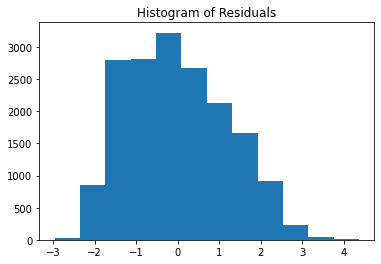

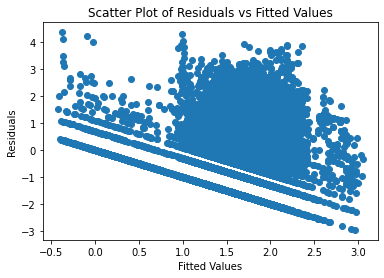

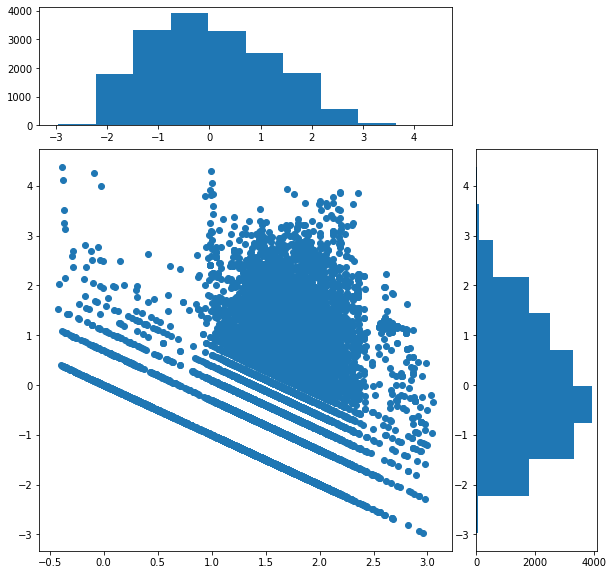

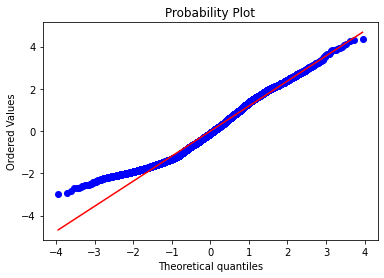

Shapiro-Wilk Test:  (0.9797584414482117, 1.317220556465328e-43)


In [50]:
###### Using logarithmic transformation on the dependent variable and re-running the model

mosquito_numlog = np.log(df_num3['Mosquito number'])

X_lin1 = df_num3.drop(columns = ['Mosquito number', 'WNV Present']) #independent variables

y_lin1 = mosquito_numlog #dependent variable

##### Adding constants

X_lin_const1 = sm.add_constant(X_lin1)

##### Instantiating our model

mosquito_model1 = sm.OLS(y_lin1, X_lin_const1)

##### Fit the model

mosquito_results1 = mosquito_model1.fit()

##### Checking our Model

print(mosquito_results1.summary())

#Residual values
mosquito_resids1 = mosquito_results1.resid

#Fitted values
mosquito_fittedvalues1 = mosquito_results1.fittedvalues

plt.figure()
plt.hist(mosquito_resids1, bins = 12)
plt.title('Histogram of Residuals')
plt.show()

plt.figure()
plt.scatter(mosquito_fittedvalues1, mosquito_resids1)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Scatter Plot of Residuals vs Fitted Values')
plt.show()

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(mosquito_fittedvalues1, mosquito_resids1)

ax_hist_x.hist(mosquito_resids1)
ax_hist_y.hist(mosquito_resids1, orientation = 'horizontal')
plt.show()


plt.figure()
stats.probplot(mosquito_resids1, dist="norm", plot = plt);
plt.show()

print("Shapiro-Wilk Test: ", stats.shapiro(mosquito_resids1))

The log transformation has increased the fit of our model, although we do still have a low R2 (0.130). 

We still need to take this a step further and drop all columns with p-values > 0.05, because they are statistically insignificant to our model.

We will drop the following columns: `CULEX TERRITANS`, `Week`, `GRAVID`

                            OLS Regression Results                            
Dep. Variable:        Mosquito number   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     324.0
Date:                Mon, 20 Jun 2022   Prob (F-statistic):               0.00
Time:                        22:06:35   Log-Likelihood:                -27803.
No. Observations:               17391   AIC:                         5.562e+04
Df Residuals:                   17382   BIC:                         5.569e+04
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const           -318.5777     11.037    -28.

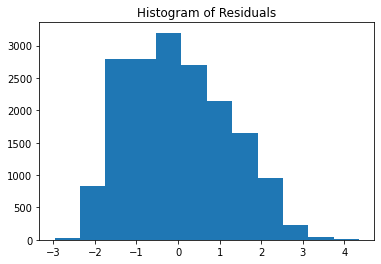

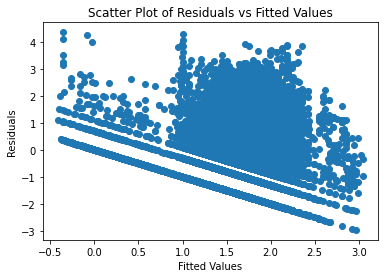

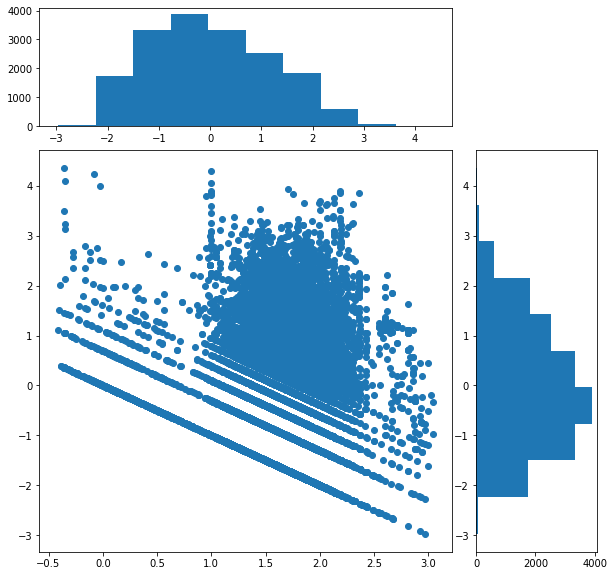

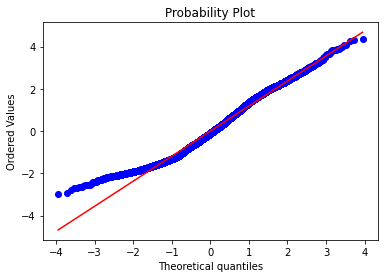

Shapiro-Wilk Test:  (0.9797160029411316, 1.2191296639625909e-43)


In [52]:
mosquito_numlog = np.log(df_num3['Mosquito number'])

X_lin2 = df_num3.drop(columns = ['Mosquito number', 'WNV Present', 'CULEX TERRITANS', 'Week', 'GRAVID']) #independent variables

y_lin2 = mosquito_numlog #dependent variable

##### Adding constants

X_lin_const2 = sm.add_constant(X_lin2)

##### Instantiating our model

mosquito_model2 = sm.OLS(y_lin2, X_lin_const2)

##### Fit the model

mosquito_results2 = mosquito_model2.fit()

##### Checking our Model

print(mosquito_results2.summary())

#Residual values
mosquito_resids2 = mosquito_results2.resid

#Fitted values
mosquito_fittedvalues2 = mosquito_results2.fittedvalues

plt.figure()
plt.hist(mosquito_resids2, bins = 12)
plt.title('Histogram of Residuals')
plt.show()

plt.figure()
plt.scatter(mosquito_fittedvalues2, mosquito_resids2)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Scatter Plot of Residuals vs Fitted Values')
plt.show()

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(mosquito_fittedvalues2, mosquito_resids2)

ax_hist_x.hist(mosquito_resids2)
ax_hist_y.hist(mosquito_resids2, orientation = 'horizontal')
plt.show()


plt.figure()
stats.probplot(mosquito_resids2, dist="norm", plot = plt);
plt.show()

print("Shapiro-Wilk Test: ", stats.shapiro(mosquito_resids2))

After dropping the statistically insignificant models, not much has changed in our model. Further fitting we can drop `Lon` and `Lat` as it is difficult to get any meaningful correlation between geographical locations without some transformation first. Furthermore, we will also drop `Month` and `Year` as their coefficients are too low and thus do not inform on the prediction of mosquito numbers.

                            OLS Regression Results                            
Dep. Variable:        Mosquito number   R-squared:                       0.079
Model:                            OLS   Adj. R-squared:                  0.078
Method:                 Least Squares   F-statistic:                     371.2
Date:                Mon, 20 Jun 2022   Prob (F-statistic):          2.60e-307
Time:                        22:12:28   Log-Likelihood:                -28299.
No. Observations:               17391   AIC:                         5.661e+04
Df Residuals:                   17386   BIC:                         5.665e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.3093      0.037      8.

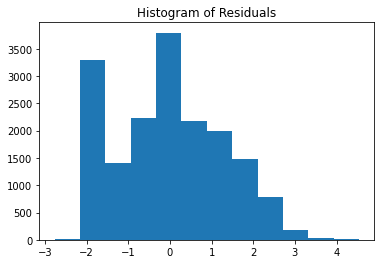

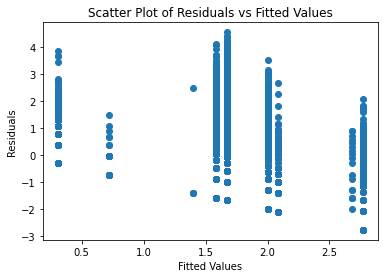

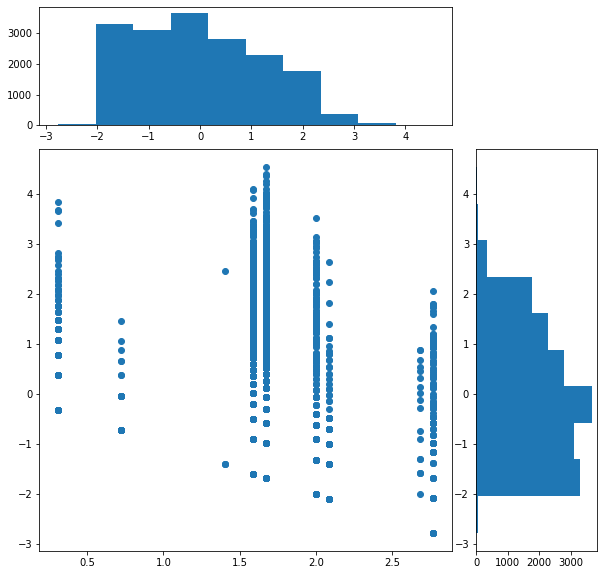

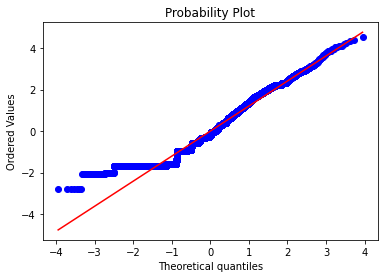

Shapiro-Wilk Test:  (0.9587694406509399, 0.0)


In [54]:
mosquito_numlog = np.log(df_num3['Mosquito number'])

X_lin3 = df_num3.drop(columns = ['Mosquito number', 'WNV Present', 'CULEX TERRITANS', 'Week', 'GRAVID', 'Lat', 'Lon', 'Month', 'Year']) #independent variables

y_lin3 = mosquito_numlog #dependent variable

##### Adding constants

X_lin_const3 = sm.add_constant(X_lin3)

##### Instantiating our model

mosquito_model3 = sm.OLS(y_lin3, X_lin_const3)

##### Fit the model

mosquito_results3 = mosquito_model3.fit()

##### Checking our Model

print(mosquito_results3.summary())

#Residual values
mosquito_resids3 = mosquito_results3.resid

#Fitted values
mosquito_fittedvalues3 = mosquito_results3.fittedvalues

plt.figure()
plt.hist(mosquito_resids3, bins = 12)
plt.title('Histogram of Residuals')
plt.show()

plt.figure()
plt.scatter(mosquito_fittedvalues3, mosquito_resids3)
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.title('Scatter Plot of Residuals vs Fitted Values')
plt.show()

from matplotlib.gridspec import GridSpec

fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 4)

ax_scatter = fig.add_subplot(gs[1:4, 0:3])
ax_hist_x = fig.add_subplot(gs[0,0:3])
ax_hist_y = fig.add_subplot(gs[1:4, 3])

ax_scatter.scatter(mosquito_fittedvalues3, mosquito_resids3)

ax_hist_x.hist(mosquito_resids3)
ax_hist_y.hist(mosquito_resids3, orientation = 'horizontal')
plt.show()


plt.figure()
stats.probplot(mosquito_resids3, dist="norm", plot = plt);
plt.show()

print("Shapiro-Wilk Test: ", stats.shapiro(mosquito_resids3))

Our model is as follows:

$$ log(y) = 1.2780x_1 + 1.3653x_2 + 0.4138x_3 + 1.0927x_4 + 0.3093 $$

*Interpretation*:

According to our model we can predict the number of mosquitos caught by the presence of two species of mosquitoes and the type of traps used.

 - The presence of CULEX PIPIENS, there is a 1.2780 increase in number of mosquitos caught.
 - the presence of CULEX RESTUANS, there is a 1.3653 increase in number of mosquitos caught.
 - The use of CDC traps means an 0.4138 increase in number of mosquitos caught.
 - The use of SENTINEL, there is a 0.3093 increase in number of mosquitos caught.
 
 
Further, because our dependent variable was log transformed we would have to apply an inverse transformation to get our predictions from the mode, that equation would be as follows:

$$ e^{log(y)} $$

---

# Logistic Regression Model

In [75]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17391 entries, 0 to 17390
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CULEX PIPIENS    17391 non-null  uint8  
 1   CULEX RESTUANS   17391 non-null  uint8  
 2   CULEX TERRITANS  17391 non-null  uint8  
 3   Year             17391 non-null  int64  
 4   Week             17391 non-null  int64  
 5   Address Block    17391 non-null  object 
 6   Trap             17391 non-null  object 
 7   Date             17391 non-null  object 
 8   WNV Present      17391 non-null  int64  
 9   Species          17391 non-null  object 
 10  Lat              17391 non-null  float64
 11  Lon              17391 non-null  float64
 12  Month            17391 non-null  int64  
 13  Mosquito number  17391 non-null  int64  
 14  CDC              17391 non-null  uint8  
 15  GRAVID           17391 non-null  uint8  
 16  SENTINEL         17391 non-null  uint8  
dtypes: float64(2

In [76]:
# The independent variables
X_logi = df4.drop(columns = ['WNV Present', 'Address Block', 'Species', 'Trap', 'Date', ])
# The dependent variable
y_logi = df4['WNV Present']

# Adding constants
X_logi_const = sm.add_constant(X_logi)
X_logi_const.head()

# Instantiate model
wnv_model = sm.Logit(y_logi, X_logi_const)

# Fit the model
wnv_model_results = wnv_model.fit()
wnv_model_results.summary()

         Current function value: 0.395050
         Iterations: 35


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                17391
Model:                          Logit   Df Residuals:                    17378
Method:                           MLE   Df Model:                           12
Date:                Tue, 21 Jun 2022   Pseudo R-squ.:                  0.1845
Time:                        00:36:49   Log-Likelihood:                -6870.3
converged:                      False   LL-Null:                       -8424.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -266.6566   1759.762     -0.152      0.880   -3715.727    3182.414
CULEX PIPIENS       1.4874      0.393      3.789      0.000       0.718       2.257
CULEX RESTUANS      1.1556      0.392      2.947      0.003       0.387       1.924
CULEX TERRITANS    -1.1208      0.476     -2.357      0.018      -2.053      -0.189
Year                0.1156      0.007     16.136      0.000       0.102       0.130
Week                0.0956      0.017      5.699      0.000       0.063       0.128
Lat                 0.4929      0.288      1.713      0.087      -0.071       1.057
Lon                 0.0665      0.357      0.186      0.852      -0.634       0.767
Month               0.1809      0.072      2.499      0.012       0.039       0.323
Mosquito number     0.0459      0.001     35.521      0.000       0.043       0.048
CDC                11.2917   1759.547      0.006      0.995   -3437.357    3459.940
GRAVID             11.2822   1759.547      0.006      0.995   -3437.366    3459.931
SENTINEL           11.1443   1759.547      0.006      0.995   -3437.504    3459.793
===================================================================================
"""

The p-value for the constant is > 0.05, this is odd, we will re-create our model while dropping the predictors that have p-values > 0.05 as they are not statistically signifanct to our model and don't predict presence of WNV.

**Re-running the model**

Re-running the model, while dropping `Lon`, `Lat`, `CDC`, `GRAVID`, and `SENTINEL`

In [78]:
# The independent variables
X_logi = df4.drop(columns = ['WNV Present', 'Address Block', 'Species', 'Trap', 'Date', 'Lon', 'Lat', 'CDC', 'GRAVID', 'SENTINEL' ])
# The dependent variable
y_logi = df4['WNV Present']


# Adding constants
X_logi_const = sm.add_constant(X_logi)
X_logi_const.head()

# Instantiate model
wnv_model = sm.Logit(y_logi, X_logi_const)

# Fit the model
wnv_model_results = wnv_model.fit()
wnv_model_results.summary()

Optimization terminated successfully.
         Current function value: 0.395237
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:            WNV Present   No. Observations:                17391
Model:                          Logit   Df Residuals:                    17383
Method:                           MLE   Df Model:                            7
Date:                Tue, 21 Jun 2022   Pseudo R-squ.:                  0.1841
Time:                        00:43:07   Log-Likelihood:                -6873.6
converged:                       True   LL-Null:                       -8424.9
Covariance Type:            nonrobust   LLR p-value:                     0.000
===================================================================================
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
const            -240.3808     13.931    -17.255      0.000    -267.684    -213.077
CULEX PIPIENS       1.4884      0.393      3.787      0.000       0.718       2.259
CULEX RESTUANS      1.1596      0.393      2.954      0.003       0.390       1.929
CULEX TERRITANS    -1.1211      0.476     -2.356      0.018      -2.054      -0.188
Year                0.1155      0.007     16.701      0.000       0.102       0.129
Week                0.0957      0.017      5.717      0.000       0.063       0.129
Month               0.1794      0.072      2.484      0.013       0.038       0.321
Mosquito number     0.0461      0.001     36.438      0.000       0.044       0.049
===================================================================================
"""

In [100]:
#Looking at our coefficients for our model
params = round(wnv_model_results.params, 3)
params

const             -240.381
CULEX PIPIENS        1.488
CULEX RESTUANS       1.160
CULEX TERRITANS     -1.121
Year                 0.116
Week                 0.096
Month                0.179
Mosquito number      0.046
dtype: float64

Our model is as follows:

$$ s(X) = P(y|X) = \frac{1}{1+e^{-(-240.381 + 1.488 x_1 + 1.160 x_2 - 1.121 x_3 + 0.116 x_4
                                   + 0.096 x_5 + 1.179 x_6 + 0.046 x_7)}} $$


In [115]:
#Storing our parameters into variables and finding the odds ratio for the predictors:


beta0 = wnv_model_results.params[0]
beta1 = wnv_model_results.params[1]
beta2 = wnv_model_results.params[2]
beta3 = wnv_model_results.params[3]
beta4 = wnv_model_results.params[4]
beta5 = wnv_model_results.params[5]
beta6 = wnv_model_results.params[6]
beta7 = wnv_model_results.params[7]

for i in params:
    betai = np.exp(params)
    print(round(betai, 3))
    break

const              0.000
CULEX PIPIENS      4.428
CULEX RESTUANS     3.190
CULEX TERRITANS    0.326
Year               1.123
Week               1.101
Month              1.196
Mosquito number    1.047
dtype: float64


This means that with one unit increase in the presense of CULEX PIPIENS species of mosquitoes, the odds of testing positive for WNV is increased by a factor of 4.428. 

Furthermore, with one unit increase of Mosquito number, the odds of the pool of mosquitoes testing positive for WNV increases by 1.047. This makes sense since we know that according to how the mosquito testing is carried out (homogenisation) the larger the number of mosquitoes in the pool the more likely there would be presence of WNV. The same goes for Month, CULEX PIPIENS as we know the time of year and species has relevancy in terms of presence of the WNV; the hotter months mean more mosquitoes, and some species of mosquitoes are major vectors of WNV.

There is a decrease in odds of getting a positive result from a pool of mosquitoes, if there is a one unit increase of CULEX TERRITANS as the odds ratio is < 1.

In [116]:
coef_df = pd.DataFrame({"coef": wnv_model_results.params, "odds_ratio": np.exp(wnv_model_results.params)})
coef_df

,coef,odds_ratio
const,-240.380831,4.017276e-105
CULEX PIPIENS,1.488378,4.429904e+00
CULEX RESTUANS,1.159617,3.188713e+00
CULEX TERRITANS,-1.121065,3.259324e-01
Year,0.115544,1.122483e+00
Week,0.095736,1.100469e+00
Month,0.179375,1.196470e+00
Mosquito number,0.046052,1.047129e+00


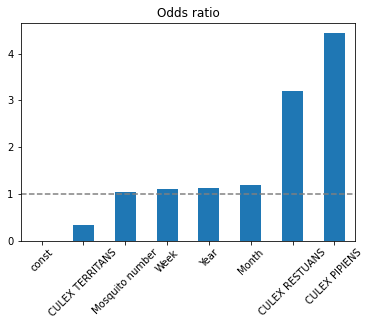

In [117]:
coef_df["odds_ratio"].sort_values().plot(kind="bar")
plt.axhline(y=1, c="gray", linestyle="--")
plt.title("Odds ratio")
plt.xticks(rotation=45)
plt.show()

In [ ]:
x_points = np.arange(0, 7, 0.01)

linear_combination = 2.369 * x_points - 4.822
probability_of_being_hired = sigmoid_curve(linear_combination)

plt.figure()
plt.plot(x_points, probability_of_being_hired)
plt.grid()
plt.xlim(0,7)
plt.xlabel("Hours Researching Role")
plt.ylabel("p - Probability of Being Hired")
plt.show()

---

# References:

https://pubmed.ncbi.nlm.nih.gov/23401954/

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6025230/
